In [1]:
from IPython.core.display import HTML
import urllib.request
request = urllib.request.Request('http://bit.ly/1Bf5Hft')
response = urllib.request.urlopen(request)
HTML(response.read().decode('utf-8'))

# project workflow
The basic workflow for project is 3 steps:
1. train a classifier to recognize whether an image is car or not
2. define sliding windows, search and classify a single image
3. build pipeline to produce output video 

# 1 compare different classifiers 

1. data exploration
2. use raw image pixels(gray) + svc
3. use raw image pixels(3D) + neural nets
4. use histogram of raw image(3D) + svc
5. use histogram of gradient (3D) + svc
6. use histogram of gradient (gray) + svc

## 1.1 data exploration, create raw dataset

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import cv2
import glob

car_paths = glob.glob('vehicles/*/*.png')
noncar_paths = glob.glob('non-vehicles/*/*.png')

In [3]:
car_paths[0]

'vehicles/GTI_Far/image0000.png'

In [17]:
n_car = len(car_paths)
n_noncar = len(noncar_paths)
n_total = n_car + n_noncar
print(n_car,n_noncar)  # check postive/negative balance

8792 8968


(64, 64, 3)


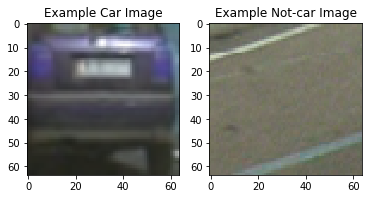

In [5]:
# read example images to see the shape and plot
car_ind = np.random.randint(0, n_car)
notcar_ind = np.random.randint(0, n_noncar)
    
car_image = cv2.imread(car_paths[car_ind])
notcar_image = cv2.imread(noncar_paths[notcar_ind])
print(car_image.shape)  # get shape (64,64,3)

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

In [21]:
raw_images = np.zeros((n_total,64,64,3),dtype = ) # (17760, 64, 64, 3)
labels = np.zeros((n_car+n_noncar,1),dtype = int)

In [22]:
np.random.shuffle(car_paths)
np.random.shuffle(noncar_paths)
for i in range(n_car):
    raw_image = cv2.imread(car_paths[i])  # bgr
    raw_images[i,:,:,:] = raw_image/255.0 -0.5 # mean 0
    labels[i] = 1
for i in range(n_noncar):
    raw_image = cv2.imread(noncar_paths[i])
    raw_images[i+n_car,:,:,:] = raw_image/255.0 -0.5
    labels[i+n_car] = 0    

In [12]:
# pickle into raw_dataset
import pickle
with open("raw_dataset.p", "wb") as f:
    pickle.dump((raw_images,labels),f) # 1.75 G, 17660*64*64*3 = 0.2 G

In [34]:
del raw_images  # save memory

## 1.2 use raw image pixels(gray) + svc

In [31]:
gray_images = np.zeros((n_total,64,64),dtype = float) # (17760, 64, 64)
for i in range(n_total):
    gray_images[i] = cv2.cvtColor(raw_images[i].astype(np.float32), cv2.COLOR_BGR2GRAY)

In [32]:
with open("gray_dataset.p", "wb") as f:
    pickle.dump((gray_images,labels),f) # 0.6 G

In [220]:
with open("gray_dataset.p", "rb") as f:
    gray_images,labels = pickle.load(f)

In [221]:
from scipy import stats
stats.describe(gray_images[0].ravel()) # see whether data is properly scaled

DescribeResult(nobs=4096, minmax=(-0.35745882987976074, 0.24344314634799957), mean=-0.14385795112102073, variance=0.016310771998914422, skewness=0.5197919240781362, kurtosis=-0.5679713742216617)

In [54]:
X = gray_images.reshape((n_total,64*64)) # (17760, 4096)
y = labels.ravel()

In [38]:
#permutation = np.random.permutation(n_total)
#shuffled_dataset = dataset[permutation,:,:]
#shuffled_labels = labels[permutation]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
y_train[0:50].T # check randomness

array([[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1]])

In [45]:
from time import time
from sklearn.svm import SVC
clf = SVC()
t0 = time()
clf.fit(X_train, y_train)
print("training time:", int(time()-t0) ) # 420 s

from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)
print(accuracy_score(y_test, y_pred)) # 0.89 

training time:416.6398751735687
0.887668918919


## 1.3 use raw image pixels(3D) + neural nets

It turns out neural nets are much faster and more accurate.

In [293]:
import pickle
with open("raw_dataset.p", "rb") as f:
    raw_images,labels = pickle.load(f)

In [295]:
from keras.utils import np_utils
Y = np_utils.to_categorical(labels, 2)

In [296]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw_images, Y, test_size=0.2, random_state=0)

In [90]:
y_train[0]

array([ 1.,  0.])

In [91]:
# use keras to implement NVIDIA architecture,  5 CNN layers, dropout and 4 dense layer
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D as Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Conv2D(6, (5, 5), strides = (2,2), activation = "relu",input_shape=(64,64,3)))
model.add(Conv2D(16,(5,5),strides = (2,2), activation = "relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2,shuffle = True, epochs=3, verbose=1)
model.save('model.h5')  # save model to .h5 file, including architechture, weights, loss, optimizer

Train on 11366 samples, validate on 2842 samples
Epoch 1/3
11366/11366 [==============================] - 30s - loss: 0.2282 - acc: 0.9036 - val_loss: 0.1210 - val_acc: 0.9497
Epoch 2/3
11366/11366 [==============================] - 12s - loss: 0.1082 - acc: 0.9604 - val_loss: 0.0945 - val_acc: 0.9659
Epoch 3/3
11366/11366 [==============================] - 12s - loss: 0.0859 - acc: 0.9681 - val_loss: 0.0817 - val_acc: 0.9659


In [297]:
# continue training
from keras.models import load_model
model = load_model('model.h5')
model.fit(X_train, y_train, validation_split=0.2,shuffle = True, epochs=5, verbose=1)

Train on 11366 samples, validate on 2842 samples
Epoch 1/5
11366/11366 [==============================] - 14s - loss: 0.0399 - acc: 0.9854 - val_loss: 0.0376 - val_acc: 0.9894
Epoch 2/5
11366/11366 [==============================] - 12s - loss: 0.0409 - acc: 0.9861 - val_loss: 0.0405 - val_acc: 0.9863
Epoch 3/5
11366/11366 [==============================] - 12s - loss: 0.0326 - acc: 0.9887 - val_loss: 0.0378 - val_acc: 0.9894
Epoch 4/5
11366/11366 [==============================] - 12s - loss: 0.0270 - acc: 0.9908 - val_loss: 0.0397 - val_acc: 0.9884
Epoch 5/5
11366/11366 [==============================] - 12s - loss: 0.0266 - acc: 0.9897 - val_loss: 0.0402 - val_acc: 0.9905


In [298]:
model.save('model.h5')
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

[0.033994937055221934, 0.99155405405405406]


In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 30, 30, 6)         456       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 13, 13, 16)        2416      
_________________________________________________________________
dropout_11 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2704)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 120)               324600    
_________________________________________________________________
dense_32 (Dense)             (None, 84)                10164     
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 170       
Total para

### test lenet

In [ ]:
# recover from last training
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
% matplotlib inline
model = load_model('model.h5')
# pickle into raw_dataset
import pickle
with open("raw_dataset.p", "wb") as f:
    pickle.dump((raw_images,labels),f) # 1.75 G, 17660*64*64*3 = 0.2 G
n_total = labels.shape[0]

prediction [1]
ground truth [1]


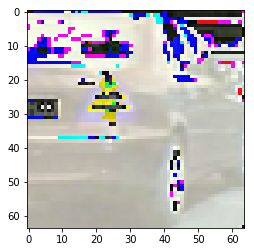

In [5]:
i = np.random.randint(0, n_total)
prob = model.predict(raw_images[i].reshape(-1,64,64,3))
pred = np.argmax(prob,axis = 1)
print("prediction",pred)
print("ground truth",labels[i])
plt.imshow(raw_images[i])

## 1.4 use histogram of raw image + svc

In [16]:
hoc_images = np.zeros((n_total,96),dtype = float) # (17760, 96)
for i in range(n_total):
    image = raw_images[i]
    bhist = np.histogram(image[:,:,0], bins=32, range=(-0.5, 0.5))  # counts, edges: lengths are 32, 33
    ghist = np.histogram(image[:,:,1], bins=32, range=(-0.5, 0.5))
    rhist = np.histogram(image[:,:,2], bins=32, range=(-0.5, 0.5))
    hoc_images[i]= np.hstack((rhist[0],ghist[0],bhist[0]))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hoc_images, labels.ravel(), test_size=0.2, random_state=0)

from time import time
from sklearn.svm import SVC
clf = SVC()
t0 = time()
clf.fit(X_train, y_train)
print("training time:", int(time()-t0) ) #  s

from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)
print(accuracy_score(y_test, y_pred)) # 0.5

5 [1]


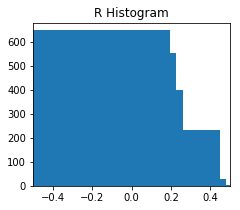

In [38]:
# check whether histogram is good 

i = np.random.randint(n_total)
print(i,labels[i])
rhist = np.histogram(raw_images[i][:,:,2], bins=32, range=(-0.5, 0.5))  # counts, edges: lengths are 32, 33
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[:-1])/2
# Plot a figure with all three bar charts
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(-0.5,0.5)
plt.title('R Histogram')

**conclusion**: histogram of color is not useful because car is more a shape instead of color

## 1.5 use histogram of gradient + svc

In [135]:
from skimage.feature import hog
hog_images = np.zeros((n_total,7*7*2*2*9*3),dtype = float) # (17760, 5292)
for i in range(n_total):
    image = raw_images[i]
    bhog = hog(image[:,:,0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    ghog = hog(image[:,:,1], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    rhog = hog(image[:,:,2], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    hog_images[i]= np.hstack((rhog.ravel(),ghog.ravel(),bhog.ravel()))

/Users/yuchaojiang/anaconda2/envs/car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [136]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(hog_images)

with open("hog_scaler.p", "wb") as f:
    pickle.dump(scaler,f)

In [46]:
from sklearn.preprocessing import StandardScaler
X = scaler.transform(hog_images)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels.ravel(), test_size=0.2, random_state=0)

from time import time
from sklearn.svm import SVC
clf = SVC()
t0 = time()
clf.fit(X_train, y_train)
print("training time:", int(time()-t0) ) #  236 s

from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)
print(accuracy_score(y_test, y_pred)) # 0.988

In [51]:
from sklearn.externals import joblib
joblib.dump(clf, 'hog_svc.pkl') 
# clf = joblib.load('filename.pkl') 

['hog_svc.pkl']

In [53]:
import pickle
with open ("hog_svc.p", "wb") as f:
    pickle.dump(clf, f)
# both method have the similar storage size, 122 MB

### try gray hog

In [98]:
import pickle
with open("raw_dataset.p", "rb") as f:
    raw_images,labels = pickle.load(f)

In [99]:
import cv2
from skimage.feature import hog
hog_gray = np.zeros((n_total,7*7*2*2*9),dtype = float) # (17760, 1764)
for i in range(n_total):
    gray = cv2.cvtColor(raw_images[i].astype(np.float32), cv2.COLOR_BGR2GRAY)
    ghog = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    hog_gray[i]= ghog.ravel() 

/Users/yuchaojiang/anaconda2/envs/car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [100]:
with open("hog_gray_dataset.p", "wb") as f:
    pickle.dump(hog_gray,f)

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(hog_gray)

with open("hog_gray_scaler.p", "wb") as f:
    pickle.dump(scaler,f)

In [59]:
X = scaler.transform(hog_gray)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels.ravel(), test_size=0.2, random_state=0)

from time import time
from sklearn.svm import SVC
clf = SVC()
t0 = time()
clf.fit(X_train, y_train)
print("training time:", int(time()-t0) ) #  78 s

from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)
print(accuracy_score(y_test, y_pred)) # 0.988

training time: 78
0.987612612613


In [60]:
from sklearn.externals import joblib
joblib.dump(clf, 'hog_gray.pkl') 
# clf = joblib.load('filename.pkl') 

['hog_gray.pkl']

In [65]:
del raw_images, X

In [66]:
del X_test,X_train, hog_gray,hog_images

# 2 define sliding windows, search and classify a single image
1. explore data to decide target area and window sizes for different area
2. create a list of sliding window
3. test gray hog svc 
4. test 3 color hog svc
5. test 3 color raw lenet
6. hotmap

In [3]:
# create a folder to store extracted images
import os
folder = 'project_frame'  
#os.mkdir(folder)

In [62]:
# use opencv to do the job
import cv2
print(cv2.__version__)  # my version is 3.1.0
vidcap = cv2.VideoCapture('project_video.mp4')
count = 0
while True:
    success,image = vidcap.read()
    if not success:
        break
    cv2.imwrite(os.path.join(folder,"{:d}.jpg".format(count)), image)     # save frame as JPEG file
    count += 1
print("{} images are extacted in {}.".format(count,folder))
# note: this is a 50-s video clip with 25 fps

3.1.0
1260 images are extacted in project_frame.


In [45]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import cv2
import glob

frame_paths = glob.glob(os.path.join(folder,'*.jpg'))
n_frame = len(frame_paths)  # 1260

### experiment

project_frame/1018.jpg


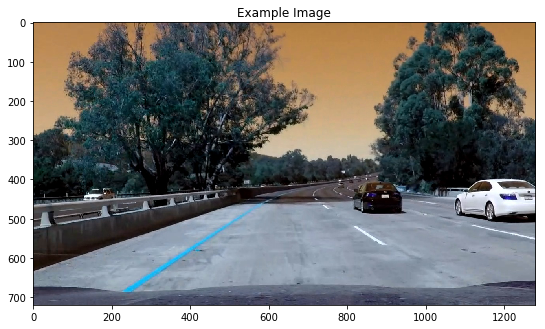

In [61]:
input_folder = folder
ind = np.random.randint(0, n_frame) # randomly choose an image
#ind = 575 # manually choose an image
input_path  = os.path.join( input_folder,"{:d}.jpg".format(ind))
image = cv2.imread(input_path)
scaled_image = image/255.0-0.5 # mean 0
#from scipy import stats
#stats.describe(scaled_image.ravel())
#print(image.shape)  # get shape (720,1280,3)
print(input_path)
if True:
    plt.figure(figsize=(9,16))
    plt.imshow(image)
    plt.title('Example Image')
    plt.show()

data exploration and observation:
1. useful portion of an image: y= (400,650), x=(400,1280)
2. the car appearing near has a size of (160,300) to (110,200)
3. the car in the faraway has a size of (20,20), may be ignore?

## 2.2 define sliding window

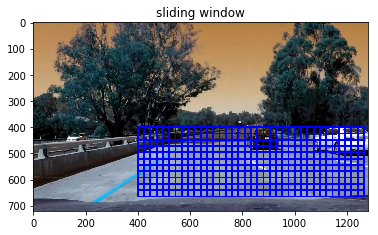

In [62]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start,x_stop, y_start,y_stop, 
                    xy_window, xy_overlap):

    # Overlap pixels, which slows down the window moving
    x_overlap = np.int(xy_window[0]*(xy_overlap[0]))
    y_overlap = np.int(xy_window[1]*(xy_overlap[1]))    
    # Compute the effective moving pixels per step
    nx_pix_per_step = xy_window[0]- x_overlap
    ny_pix_per_step = xy_window[1]- y_overlap
    # Compute the number of windows in x/y
    nx_windows = np.int((x_stop - x_start-x_overlap)/nx_pix_per_step) 
    ny_windows = np.int((y_stop - y_start-y_overlap)/ny_pix_per_step) 

    window_list = []
    for y in range(ny_windows):
        for x in range(nx_windows):       
            startx = x * nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = y * ny_pix_per_step + y_start
            endy = starty + xy_window[1]      
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

y_height, x_width, channel = image.shape
windows = slide_window(image, 400,1280, 400, 680, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.title('sliding window')
plt.show()

## 2.3 test gray hog svc 

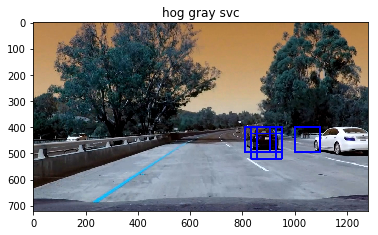

In [63]:
# use gray hog svc predictor
from sklearn.externals import joblib
import pickle
from skimage.feature import hog
clf = joblib.load('hog_gray.pkl') 
with open ('hog_gray_scaler.p','rb') as f:
    scaler = pickle.load(f)
on_windows = []
for window in windows:
    test_img = cv2.resize(scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
    gray = cv2.cvtColor(test_img.astype(np.float32), cv2.COLOR_BGR2GRAY)
    ghog = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    hog_gray= ghog.ravel() 
    test_features = scaler.transform(np.array(hog_gray).reshape(1, -1))
    prediction = clf.predict(test_features)
    if prediction == 1:
        on_windows.append(window)

window_img = draw_boxes(image, on_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.title('hog gray svc')
plt.show()

## 2.4 test bgr hog svc

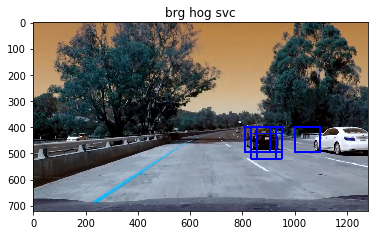

In [64]:
# use 3 color hog svc predictor
#image = cv2.imread(frame_paths[ind])
clf = joblib.load('hog_svc.pkl') 
with open ('hog_scaler.p','rb') as f:
    scaler = pickle.load(f)
on_windows = []
for window in windows:
    blue = scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0], 0]
    green= scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0], 1]
    red  = scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0], 2]
    bhog = hog(cv2.resize(blue, (64, 64)), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    ghog = hog(cv2.resize(green,(64, 64)), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    rhog = hog(cv2.resize(red,  (64, 64)), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    hog_image = np.hstack((rhog.ravel(),ghog.ravel(),bhog.ravel()))
    test_features = scaler.transform(hog_image.reshape(1, -1))
    prediction = clf.predict(test_features)
    if prediction == 1:
        on_windows.append(window)

window_img = draw_boxes(image, on_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.title('brg hog svc')
plt.show()

## 2.5 test bgr lenet

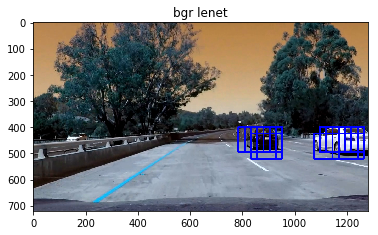

In [65]:
# use lenet predictor
from keras.models import load_model
model = load_model('model.h5')

on_windows = []
for window in windows:
    test_img = cv2.resize(scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
    prob = model.predict(test_img.reshape(-1,64,64,3))
    prediction = np.argmax(prob,axis = 1)
    if prediction[0] == 1:
        on_windows.append(window)
        
window_img = draw_boxes(image, on_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.title('bgr lenet')
plt.show()

# 2.6 heat map

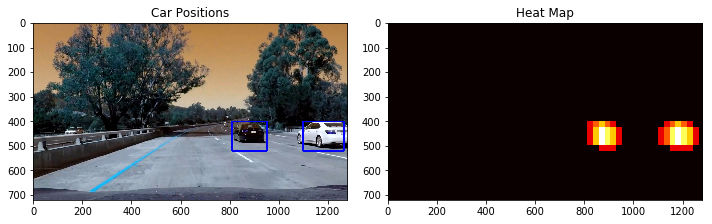

In [68]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(image[:,:,0]).astype(np.float)
for box in on_windows:
    heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

threshold = 1
heat[heat <= threshold] = 0

labels,num  = label(heat)
img = np.copy(image)
for car_number in range(1, num+1):
    nonzero = (labels == car_number).nonzero() 
    boxpoint1 = (min(nonzero[1]), min(nonzero[0]))  # (x,y)
    boxpoint2 = (max(nonzero[1]), max(nonzero[0]))        
    cv2.rectangle(img, boxpoint1, boxpoint2, (0,0,255), 6)

fig = plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.title('Car Positions')

plt.subplot(122)
plt.imshow(heat,cmap="hot")
plt.title('Heat Map')
fig.tight_layout()

# build pipeline to produce output video 

In [34]:
input_folder = 'project_frame' 
output_folder = 'project_output5' 
os.mkdir(output_folder)

In [69]:
# use lenet predictor
from keras.models import load_model
model = load_model('model.h5')
windows = slide_window(image, 400,1280, 400, 680, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

from time import time
t0 = time()
for ind in range(n_frame):
    input_path  = os.path.join( input_folder,"{:d}.jpg".format(ind))
    output_path = os.path.join(output_folder,"{}.jpg".format(str(ind).zfill(4)))
    image = cv2.imread(input_path)
    scaled_image = image/255.0-0.5
    
    on_windows = []
    for window in windows:
        test_img = cv2.resize(scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #test_img = scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        prob = model.predict(test_img.reshape(-1,64,64,3))
        prediction = np.argmax(prob,axis = 1)[0]
        if prediction == 1:
            on_windows.append(window)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for box in on_windows:
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    threshold = 1
    heat[heat <= threshold] = 0

    labels,num  = label(heat)
    img = np.copy(image)
    for car_number in range(1, num+1):
        nonzero = (labels == car_number).nonzero() 
        boxpoint1 = (min(nonzero[1]), min(nonzero[0]))  # (x,y)
        boxpoint2 = (max(nonzero[1]), max(nonzero[0]))        
        cv2.rectangle(img, boxpoint1, boxpoint2, (0,0,255), 6)
    
    cv2.imwrite(output_path, img) 
    if ind % 100 == 0:
        print(ind, time()-t0)
print("mission complete in {:4.2f} s".format(time()-t0))
# xy_window=(128, 128), xy_overlap=(0.75, 0.75) takes 360 s, fail to detect 550-562, 590s
# xy_window=(64, 64), xy_overlap=(0.5, 0.5)         'project_output' takes 444 s, false positive
# xy_window=(64, 64), xy_overlap=(0.5, 0.5),th =1, 'project_output1' takes 462 s, false positive, 361,371s
# xy_window=(64, 64), xy_overlap=(0.5, 0.5),th =2,  'project_output2' takes 435 s. false postive: 1041, false negative:575
# xy_window=(64, 64), xy_overlap=(0.75, 0.75),th =3,'project_output3', takes 1570s
# xy_window=(96, 96), xy_overlap=(0.5, 0.75),th =2, 'project_output4', takes 325 s, no false positive
# xy_window=(96, 96), xy_overlap=(0.75, 0.75),th =1, 'project_output2', takes 325 s, sometime car is filter out
# note: car apprears from 110 frames


0 0.6584160327911377
100 43.62028384208679
200 86.92935299873352
300 129.40399384498596
400 171.73358297348022
500 214.67221403121948
600 256.5104088783264
700 298.4364538192749
800 342.123165845871
900 385.29753398895264
1000 429.1989619731903
1100 474.74634885787964
1200 518.3113288879395
mission complete in 543.37 s


In [71]:
# combine frames to video
from moviepy.editor import ImageSequenceClip
output_folder ='project_output2'
imageList = glob.glob(os.path.join(output_folder, "*") ) # the file must in order with their sequence
clip = ImageSequenceClip(imageList, fps=25)
video_file = output_folder + '.mp4'
clip.write_videofile(video_file)

[MoviePy] >>>> Building video project_output2.mp4
[MoviePy] Writing video project_output2.mp4


100%|██████████| 1260/1260 [00:54<00:00, 23.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output2.mp4 

